In [3]:
#Importing libraries
import pandas as pd
import yfinance as yf
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import keras
from keras.layers import Dense
from keras.layers import LSTM
from keras.layers import Dropout

In [4]:
# Pulling the  Data 
eth_data = yf.download('ETH-USD', start='2017-01-01', end='2022-01-01')
eth_df = pd.DataFrame(eth_data)

[*********************100%***********************]  1 of 1 completed


In [5]:
eth_df = eth_df.drop(columns=['Adj Close','Volume', 'Open', 'High', 'Low'])
eth_df.head()

,Close
Date,
2017-11-09,320.884003
2017-11-10,299.252991
2017-11-11,314.681000
2017-11-12,307.907990
2017-11-13,316.716003


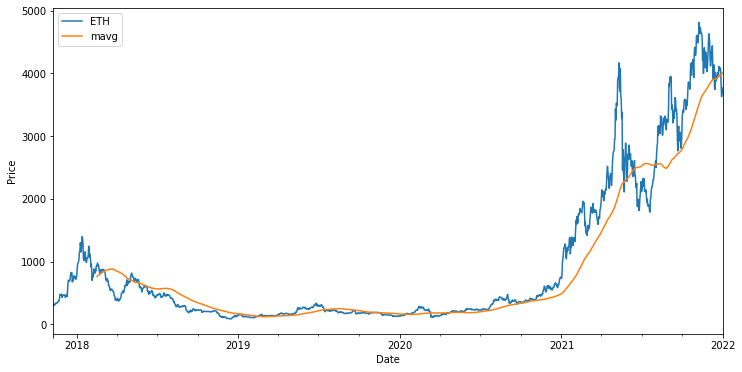

In [6]:
# Rolling mean
close_px = eth_df['Close']
mavg = close_px.rolling(window=100).mean()

plt.figure(figsize = (12,6))
close_px.plot(label='ETH')
mavg.plot(label='mavg')
plt.xlabel('Date')
plt.ylabel('Price')
plt.legend()

In [7]:
import matplotlib.dates as mdates

# change the dates into ints for training 
dates_df = eth_df.copy()
dates_df = dates_df.reset_index()

# Store the original dates for plotting the predicitons
org_dates = dates_df['Date']

# convert to ints
dates_df['Date'] = dates_df['Date'].map(mdates.date2num)

dates_df.tail()

,Date,Close
1510,738152.0,3800.893066
1511,738153.0,3628.531738
1512,738154.0,3713.852051
1513,738155.0,3682.632812
1514,738156.0,3769.697021


/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:993: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


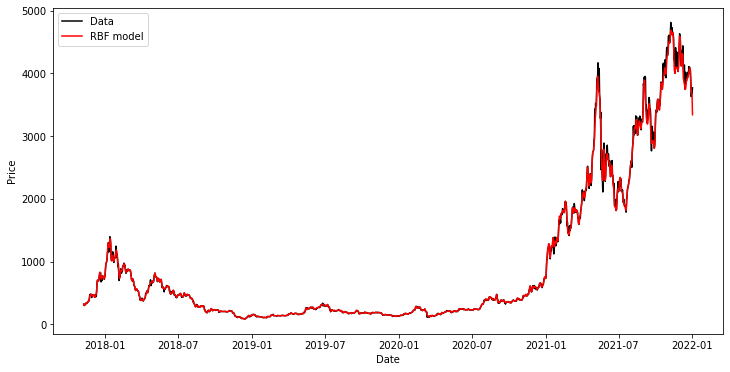

In [8]:
# Use sklearn support vector regression to predicit our data:
from sklearn.svm import SVR

dates = dates_df['Date'].to_numpy() 
prices = eth_df['Close'].to_numpy()

#Convert to 1d Vector
dates = dates.reshape(-1, 1)
prices = prices.reshape(-1, 1)

svr_rbf = SVR(kernel= 'rbf', C= 1e3, gamma= 0.1)
svr_rbf.fit(dates, prices)

plt.figure(figsize = (12,6))
plt.plot(dates, prices, color= 'black', label= 'Data')
plt.plot(org_dates, svr_rbf.predict(dates), color= 'red', label= 'RBF model') 
plt.xlabel('Date')
plt.ylabel('Price')
plt.legend()
plt.show()

In [10]:
# Create train set of adj close prices data:
train_data = eth_df.loc[:,'Close'].to_numpy()
print(train_data.shape) 

(1515,)


In [11]:
# Apply normalization before feeding to LSTM using sklearn:
from sklearn.preprocessing import MinMaxScaler

scaler = MinMaxScaler()
train_data = train_data.reshape(-1,1)

scaler.fit(train_data)
train_data = scaler.transform(train_data)

In [12]:
def window_data(df, window, feature_col_number, target_col_number):
    X = []
    y = []
    for i in range(len(df) - window - 1):
        features = df.iloc[i:(i + window), feature_col_number]
        target = df.iloc[(i + window), target_col_number]
        X.append(features)
        y.append(target)
    return np.array(X), np.array(y).reshape(-1, 1)

In [14]:
# Predict Closing Prices using a 10 day window of previous closing prices
# Then, experiment with window sizes anywhere from 1 to 10 and see how the model performance changes
window_size = 10

# Column index 0 is the 'fng_value' column
# Column index 1 is the `Close` column
feature_column = 0
target_column = 0
X, y = window_data(eth_df, window_size, feature_column, target_column)

In [15]:
 # Use 70% of the data for training and the remaineder for testing
split = int(.7 * len(X))
X_train = X[:split - 1]
X_test = X[split:]
y_train = y[:split - 1]
y_test = y[split:]

In [16]:
# Use the MinMaxScaler to scale data between 0 and 1.
from sklearn.preprocessing import MinMaxScaler
x_scaler = MinMaxScaler()
y_scaler = MinMaxScaler()

# Fit the scaler for the training Data
x_scaler.fit(X_train)
y_scaler.fit(y_train)

# Scale the training data
X_train = x_scaler.transform(X_train)
y_train = y_scaler.transform(y_train)

# Scale the y_test data
X_test = x_scaler.transform(X_test)
y_test = y_scaler.transform(y_test)

In [17]:
 # Reshape the features for the model
X_train = X_train.reshape((X_train.shape[0], X_train.shape[1], 1))
X_test = X_test.reshape((X_test.shape[0], X_test.shape[1], 1))

In [18]:
# Build the model 
model = keras.Sequential()

model.add(LSTM(units = 100, return_sequences = True, input_shape = (X_train.shape[1], 1)))
model.add(Dropout(0.2))

model.add(LSTM(units = 100))
model.add(Dropout(0.2))

# Output layer
model.add(Dense(units = 1))

# Compiling the model
model.compile(optimizer = 'adam', loss = 'mean_squared_error')

# Fitting the model to the Training set
history = model.fit(X_train, y_train, epochs = 20, batch_size = 10, validation_split=.30)

Epoch 1/20
74/74 [==============================] - 10s 44ms/step - loss: 0.0087 - val_loss: 3.8045e-04
Epoch 2/20
74/74 [==============================] - 3s 39ms/step - loss: 0.0033 - val_loss: 8.8259e-04
Epoch 3/20
74/74 [==============================] - 3s 40ms/step - loss: 0.0025 - val_loss: 5.1453e-04
Epoch 4/20
74/74 [==============================] - 3s 38ms/step - loss: 0.0026 - val_loss: 4.9422e-04
Epoch 5/20
74/74 [==============================] - 2s 34ms/step - loss: 0.0022 - val_loss: 0.0014
Epoch 6/20
74/74 [==============================] - 3s 40ms/step - loss: 0.0021 - val_loss: 2.9062e-04
Epoch 7/20
74/74 [==============================] - 3s 35ms/step - loss: 0.0023 - val_loss: 3.1217e-04
Epoch 8/20
74/74 [==============================] - 3s 37ms/step - loss: 0.0020 - val_loss: 2.1967e-04
Epoch 9/20
74/74 [==============================] - 3s 43ms/step - loss: 0.0019 - val_loss: 5.4372e-04
Epoch 10/20
74/74 [==============================] - 3s 37ms/step - loss: 0.

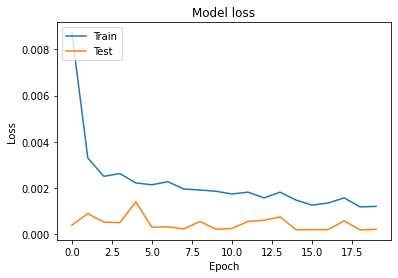

In [19]:
# Plot training & validation loss values
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='upper left')
plt.show()

In [20]:
# store the original vals for plotting the predictions 
#y_test = y_test.reshape(-1,1)
org_y = scaler.inverse_transform(y_test)

# reshape it [samples, time steps, features]
#X_test = np.reshape(X_test, (X_test.shape[0], 36, 1))

# Predict the prices with the model
predicted_y = model.predict(X_test)
predicted_y = scaler.inverse_transform(predicted_y)

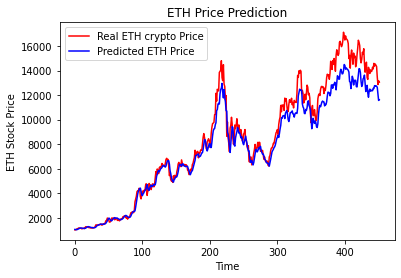

In [21]:
plt.plot(org_y, color = 'red', label = 'Real ETH crypto Price')
plt.plot(predicted_y, color = 'blue', label = 'Predicted ETH Price')
plt.title('ETH Price Prediction')
plt.xlabel('Time')
plt.ylabel('ETH Stock Price')
plt.legend()
plt.show()